In [44]:
%matplotlib inline

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from tqdm.auto import tqdm

from pydub import AudioSegment
from pydub.silence import detect_nonsilent, detect_silence
from pydub.silence import split_on_silence
import numpy as np
import ffmpeg
import itertools

from os import listdir
from os.path import isfile, join

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [47]:
# def match_target_amplitude(sound, target_dBFS):
#     change_in_dBFS = target_dBFS - sound.dBFS
#     return sound.apply_gain(change_in_dBFS)

# with open("./records/_records.txt") as f:
#     contents = f.readlines()
# onlyfiles = [f for f in listdir("./records/") if isfile(join("./records/", f))]
# onlyfiles = list(filter(lambda x: ".wav" in x, onlyfiles))

# data = []

# for file in onlyfiles:
#     name = file[:file.rfind(".")]
#     audio_segment = AudioSegment.from_wav("./records/" + name + ".wav")
#     normalized_sound = match_target_amplitude(audio_segment, -20.0)
#     audio_chunks = detect_silence(normalized_sound, min_silence_len=300, silence_thresh=-30, seek_step=1)
#     chained_chunks = list(itertools.chain(*audio_chunks))

#     res = list(filter(lambda x: name in x, contents))[0]
#     mood = 0
#     if "bad" in res:
#         mood = 0
#     if "neutral" in res:
#         mood = 1
#     if "good" in res:
#         mood = 2
#     data.append((mood, name + ".wav", chained_chunks))

# print(data)
# pd.DataFrame(data).to_csv("./chunks/chunks.csv")

In [48]:
from ast import literal_eval

file_name = './chunks/chunks.csv'
df = pd.read_csv(file_name)
df = df.drop('file_name', axis=1)
df = df.drop('drop_id', axis=1)
df['chunks'].replace('[]', np.nan, inplace=True)
df.dropna(subset=['chunks'], inplace=True)
df.chunks = df.chunks.apply(literal_eval)
df.reset_index(drop=True, inplace=True)

df.shape[0]

144

In [49]:
from torch.utils.data import Dataset

class transcription_dataset(Dataset):
 
  def __init__(self,file_name):
    file_name = './chunks/chunks.csv'
    df = pd.read_csv(file_name)
    df = df.drop('file_name', axis=1)
    df = df.drop('drop_id', axis=1)
    df['chunks'].replace('[]', np.nan, inplace=True)
    df.dropna(subset=['chunks'], inplace=True)
    df.chunks = df.chunks.apply(literal_eval)
    df.reset_index(drop=True, inplace=True)

    audio_max_length = 15000
    x = df.label.values
    y = df.iloc[:,1].values
    
    self.x_train = x
    self.y_train = y
    self.max_len = len(max(y, key=len))
 
  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx], self.y_train[idx]

In [50]:
db = transcription_dataset('./chunks/chunks.csv')

In [51]:
train_set, test_set = torch.utils.data.random_split(db, [0.7, 0.3])

In [52]:
train_dataset, test_dataset  = train_set, test_set
target_classes = ["bad", "neutral", "good"]

In [53]:
train_dataset[3]

(1, [0, 4431, 6318, 8527, 8787, 9154, 12973, 13470, 13780, 15120])

In [54]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn_padd(batch):
    Y, X = list(zip(*batch))
    X = list(X)
    padded = torch.tensor([row + [0] * (db.max_len - len(row)) for row in X])
    
    return torch.tensor(padded, dtype=torch.float32), torch.tensor(Y)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn_padd, shuffle=True)
test_loader  = DataLoader(test_dataset , batch_size=batch_size, collate_fn=collate_fn_padd)

## Model

In [55]:
class silent_gap_nn(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(db.max_len, 768),
            nn.ReLU(),
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, len(target_classes)),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Training and Testing

In [56]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target, *_) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)

        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        # loss = F.nll_loss(output.squeeze(), target)
        loss = F.cross_entropy(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch}\t[{(batch_idx * len(data)):5.0f}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):3.0f}%)]\tLoss: {loss.item():.4f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [57]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
  
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    accuracy = 100. * correct / len(test_loader.dataset)
    print(f" Test Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n")
    return accuracy

In [58]:
log_interval = 20
n_epoch = 40
learning_rate = 0.00001

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
accuracies = []

model = silent_gap_nn()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.2)  # reduce the learning after 4 epochs by a factor of 10

with tqdm(total=n_epoch, 
          bar_format = "{desc}: {percentage:.2f}%|{bar}| {n:.2f}/{total_fmt} [{elapsed}<{remaining}]",
          colour = 'GREEN',
          ) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        accuracy_step = test(model, epoch)
        accuracies.append(accuracy_step)
        scheduler.step()


0.00%|          | 0.00/40 [00:00<?]

C:\Users\ioci\AppData\Local\Temp\ipykernel_17988\465534958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(padded, dtype=torch.float32), torch.tensor(Y)


Train Epoch: 1	[    0/101 (  0%)]	Loss: 413.9416
 Test Epoch: 1	Accuracy: 20/43 (47%)

Train Epoch: 2	[    0/101 (  0%)]	Loss: 28.0993
 Test Epoch: 2	Accuracy: 19/43 (44%)

Train Epoch: 3	[    0/101 (  0%)]	Loss: 46.2963
 Test Epoch: 3	Accuracy: 20/43 (47%)

Train Epoch: 4	[    0/101 (  0%)]	Loss: 22.6308
 Test Epoch: 4	Accuracy: 19/43 (44%)

Train Epoch: 5	[    0/101 (  0%)]	Loss: 27.4735
 Test Epoch: 5	Accuracy: 19/43 (44%)

Train Epoch: 6	[    0/101 (  0%)]	Loss: 12.0886
 Test Epoch: 6	Accuracy: 18/43 (42%)

Train Epoch: 7	[    0/101 (  0%)]	Loss: 18.6260
 Test Epoch: 7	Accuracy: 18/43 (42%)

Train Epoch: 8	[    0/101 (  0%)]	Loss: 14.3487
 Test Epoch: 8	Accuracy: 18/43 (42%)

Train Epoch: 9	[    0/101 (  0%)]	Loss: 11.0532
 Test Epoch: 9	Accuracy: 22/43 (51%)

Train Epoch: 10	[    0/101 (  0%)]	Loss: 2.2077
 Test Epoch: 10	Accuracy: 20/43 (47%)

Train Epoch: 11	[    0/101 (  0%)]	Loss: 0.3082
 Test Epoch: 11	Accuracy: 22/43 (51%)

Train Epoch: 12	[    0/101 (  0%)]	Loss: 8.3834
 Te

Text(0.5, 1.0, 'training loss')

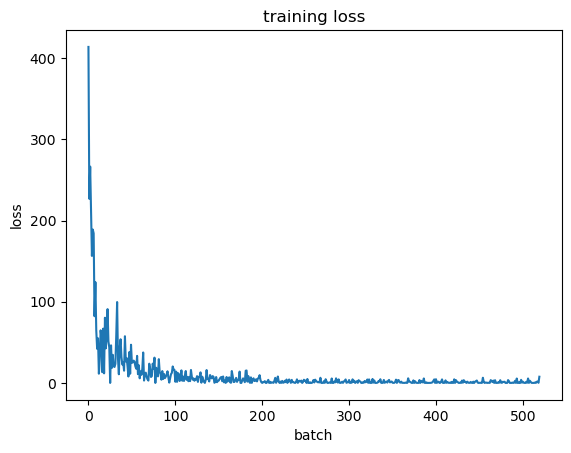

In [59]:
plt.plot(losses)
plt.xlabel('batch')
plt.ylabel('loss')
plt.title("training loss")

Text(0.5, 1.0, 'validation accuracy')

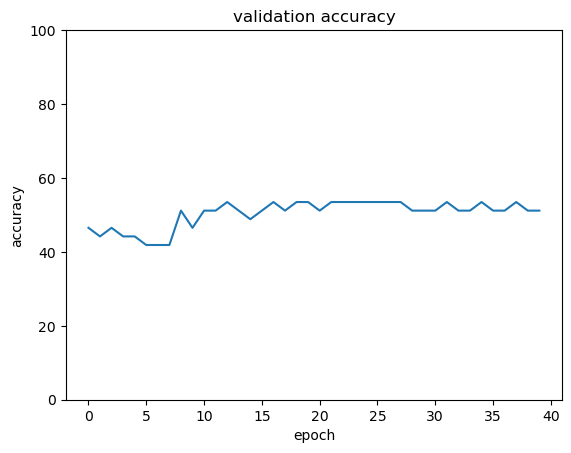

In [60]:
ax = plt.plot(accuracies)

plt.ylim(0, 100)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xticks(range(0, len(accuracies)+1, 5))
plt.title("validation accuracy")

In [61]:
print(count_parameters(model))

545027


[1 1 0 1 1 0 1 1 1 1 0 2 1 2 2 1 1 2 0 2 1 2 1 1 1 1 2 2 0 1 1 0 1 1 0 0 1
 1 2 0 2 2 2]
              precision    recall  f1-score   support

        good       0.25      0.22      0.24         9
         bad       0.62      0.73      0.67        22
     neutral       0.44      0.33      0.38        12

    accuracy                           0.51        43
   macro avg       0.44      0.43      0.43        43
weighted avg       0.49      0.51      0.50        43



C:\Users\ioci\AppData\Local\Temp\ipykernel_17988\465534958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(padded, dtype=torch.float32), torch.tensor(Y)


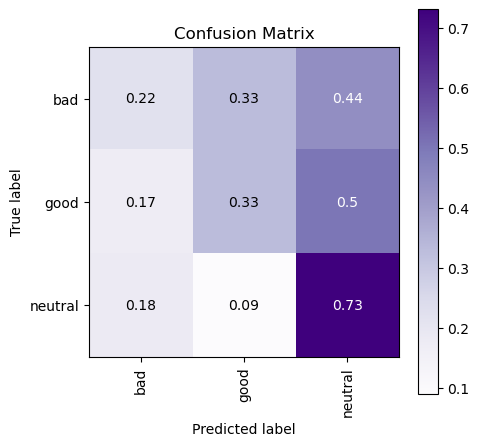

In [62]:
target_classes = {0:"bad", 1:"neutral", 2:"good"}

def print_results(Y_actual, Y_preds, target_names):
    from sklearn.metrics import confusion_matrix, classification_report
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    
    tcs = ["good", "bad", "neutral"]
    print(classification_report(Y_actual, Y_preds, target_names=tcs))
    skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                        normalize=True,
                                        title="Confusion Matrix",
                                        cmap="Purples",
                                        hide_zeros=True,
                                        figsize=(5,5)
                                        )
    plt.xticks(rotation=90)

def make_predictions(model):
    Y_shuffled, Y_preds = [], []

    model.eval()
    correct = 0

    with torch.no_grad():
       for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
  
        predicted_label = model(data)

        Y_preds.append(predicted_label)
        Y_shuffled.append(target)
            
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().cpu().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().cpu().numpy()


Y_actual, Y_preds = make_predictions(model)
print(Y_actual)
print_results(Y_actual, Y_preds, target_classes)